## Business + Data Understanding

Gather necessary data to answer your questions

Handle categorical and missing data

Provide insight into the methods you chose and why you chose them

In [242]:
import sys
!{sys.executable} -m pip install mplleaflet

  Created wheel for mplleaflet: filename=mplleaflet-0.0.5-cp37-none-any.whl size=28561 sha256=c4fea63123082941732b187b4ee84c5f9f4932b3cfee4a93b8f79eb85aca31ad
  Stored in directory: C:\Users\tatheoto\AppData\Local\pip\Cache\wheels\bf\fd\0b\0513de62c339c4a56e2234aa42a5d06e6660a4446fdae7b796
Successfully built mplleaflet


In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from collections import defaultdict
import datetime  
from datetime import date, timedelta
import mplleaflet

%matplotlib inline

listing_df = pd.read_csv('./listings_seattle.csv')
calendar_df = pd.read_csv('./calendar_seattle.csv')
reviews_df = pd.read_csv('./reviews_seattle.csv')

### Understanding the data

Starting with the listing_df file, we will look into its parameters and try to understand the data.

In [244]:
rows = listing_df.shape[0]
cols = listing_df.shape[1]

In [245]:
name_cols = listing_df.columns

In [246]:
cat_df = listing_df.select_dtypes(include=['object'])

In [247]:
#I created groups of columns with relevant information about a certain aspect of AirBnB's listings
#General Information
gen_cols = ['id', 'name']

#Text Description
text_cols = ['summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit']

#Host Info
host_cols = ['host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified']

#Location Info
loc_cols = ['street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 
       'smart_location', 'latitude', 'longitude',
       'is_location_exact']

#Apartment Info
apt_cols = ['property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet']

#Price Info
price_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people']

#Availability
aval_cols = ['minimum_nights', 'maximum_nights', 'calendar_updated', 
       'availability_30', 'availability_60', 'availability_90',
       'availability_365']

#Reviews - Satisfaction
rev_cols = ['number_of_reviews', 
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month']

#Booking
book_cols = ['instant_bookable', 'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification']


### Plotting the data

Helps visualizing and understanding the information. To understand which percentage of values falls into a certain category, I used bar plots and the relative frequency of each data point.

C:\Users\tatheoto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


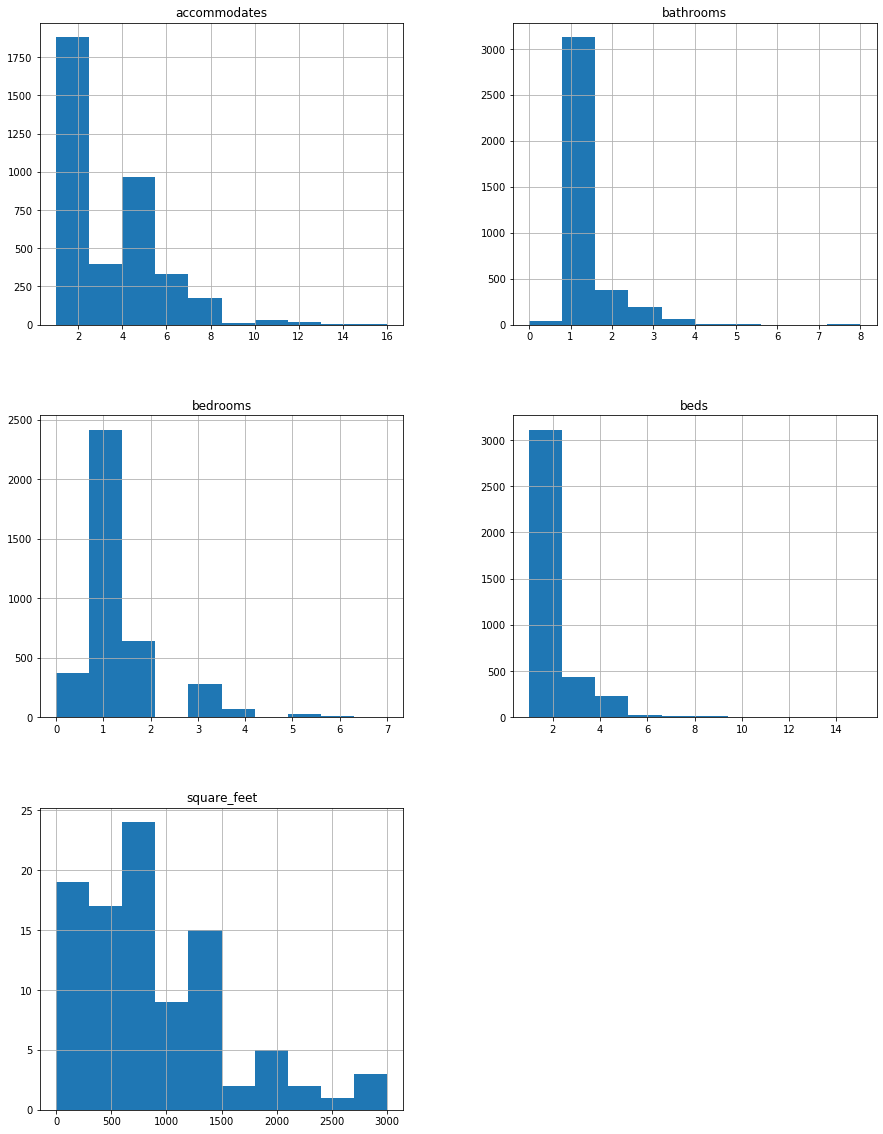

In [248]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
listing_df[apt_cols].hist(ax = ax);

In [249]:
def bar_plot_prop(df, col):
    (df[col].value_counts()/(df.shape[0]-sum(df[col].isnull()))).plot(kind='bar');

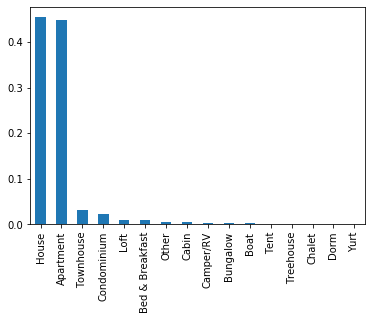

In [37]:
bar_plot_prop(listing_df, 'property_type')

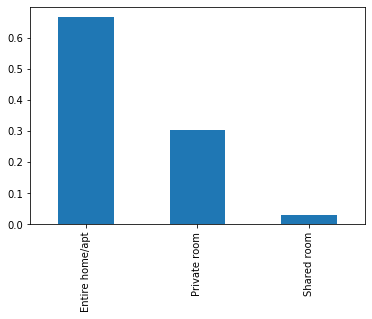

In [40]:
bar_plot_prop(listing_df, 'room_type')

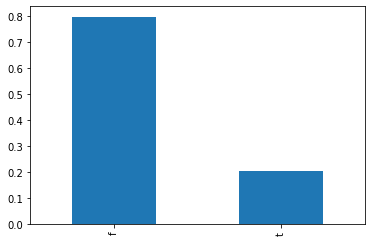

In [41]:
bar_plot_prop(listing_df, 'host_is_superhost')

### Cleaning the data

First I will locate which columns can be deleted (i.e., with a single value). Then, I will analyse which columns have the highest percentage of missing values.

In [250]:
#Identifying and dropping columns with only one value

uni_cols = []

for col in listing_df.columns:
    if len(listing_df[col].unique()) == 1:
        uni_cols.append(col)
        listing_df = listing_df.drop(columns=[col])

In [251]:
#Checking for columns with > 25% missing values

for col in listing_df.columns:
    if listing_df[col].isnull().mean() > 0.25:
        print("The column {} has {:.1f}% of missing values".format(col , 100*listing_df[col].isnull().mean()))

The column neighborhood_overview has 27.0% of missing values
The column notes has 42.1% of missing values
The column square_feet has 97.5% of missing values
The column weekly_price has 47.4% of missing values
The column monthly_price has 60.3% of missing values
The column security_deposit has 51.1% of missing values
The column cleaning_fee has 27.0% of missing values


The price data is saved as a string. The next cells transform the relevant data points into floats.

In [252]:
#function was needed in order to try/except values; np.nan values cannot be transformed into float
def clean_price(x):
    try:
        return float(x.replace('$', '').replace(',', ''))
    except:
        return x

In [253]:
for col in price_cols:
    listing_df[col] = listing_df[col].apply(lambda x: clean_price(x))

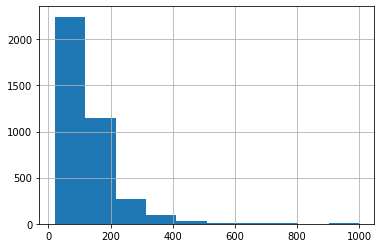

In [254]:
listing_df['price'].hist(bins=10);

The host_response_rate is also saved as a percentage string. We will also change it to numbers.

In [255]:
def clean_perc(x):
    try:
        return float(x.replace('%', ''))/100
    except:
        return x
    
listing_df['host_response_rate'] = listing_df['host_response_rate'].apply(lambda x: clean_perc(x))

Now it's time to clean multiple selection columns.

In [256]:
#Finding all possible values in a column with multiple value selection

find_unique = lambda x: x.replace("[", '').replace("]", '').replace(",", '')

unique_vals = list(set(listing_df['host_verifications'].apply(find_unique).str.cat(sep=' ').split(' ')))

In [257]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    for val in look_for:
        for row in range(df.shape[0]):
            if val in df[col1][row]:
                new_df[val] += int(df[col2][row])

    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values(col2, ascending=False, inplace=True)
    return new_df

In [258]:
possible_vals = unique_vals

def clean_and_plot(df, col, title, plot=True):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    study = df[col].value_counts().reset_index()
    study_df = total_count(study, 'index', col, possible_vals)
    study_df.set_index('index', inplace=True)
    
    if plot:
        (study_df/study_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_study_df = study_df/study_df.sum()
    return props_study_df

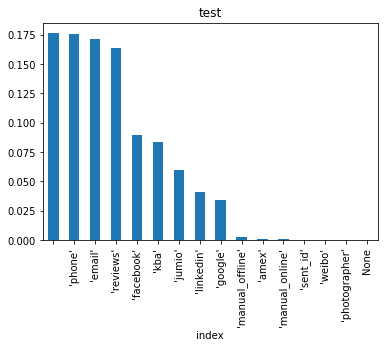

,host_verifications
index,
,0.176408
'phone',0.175161
'email',0.171233
'reviews',0.163979
'facebook',0.089082
'kba',0.083907
'jumio',0.059557
'linkedin',0.041168
'google',0.034422


In [259]:
clean_and_plot(listing_df, 'host_verifications', 'test')

In [260]:
listing_df.groupby('host_response_time').mean()['review_scores_rating']

host_response_time
a few days or more    87.793103
within a day          94.264831
within a few hours    93.812425
within an hour        95.143984
Name: review_scores_rating, dtype: float64

In [161]:
listing_df.groupby('host_response_rate').mean()['review_scores_rating']

host_response_rate
0.17    100.000000
0.25     97.500000
0.30    100.000000
0.31     97.000000
0.33     90.818182
0.38    100.000000
0.40     73.142857
0.43     85.750000
0.50     94.257143
0.53     94.000000
0.55           NaN
0.56    100.000000
0.57     81.000000
0.58     92.000000
0.60     94.588235
0.63     95.777778
0.64     91.666667
0.65    100.000000
0.67     93.129032
0.68           NaN
0.69     85.000000
0.70     90.954545
0.71     85.250000
0.75     94.413793
0.76     95.333333
0.78     94.333333
0.80     88.870968
0.81     94.000000
0.82     92.500000
0.83     94.750000
0.86     92.703704
0.87     93.333333
0.88     93.529412
0.89     92.448276
0.90     93.527027
0.91     96.000000
0.92     92.000000
0.93     93.941176
0.94     94.195122
0.95     97.857143
0.96     92.058824
0.97     91.000000
0.98     93.678571
0.99     92.306452
1.00     95.277885
Name: review_scores_rating, dtype: float64

In [163]:
listing_df.groupby('host_is_superhost').mean()['review_scores_rating']

host_is_superhost
f    93.652893
t    97.395473
Name: review_scores_rating, dtype: float64

In [164]:
listing_df.groupby('host_listings_count').mean()['review_scores_rating']

host_listings_count
1.0      95.279748
2.0      94.233273
3.0      94.938865
4.0      93.983740
5.0      93.988235
6.0      94.179487
7.0      90.826087
8.0      92.227273
9.0      93.814815
10.0     94.826087
11.0     87.666667
12.0     95.714286
13.0     97.750000
15.0     91.333333
17.0     87.300000
18.0     92.526316
19.0     80.000000
21.0     92.761905
34.0     86.338462
36.0     92.931034
37.0     89.857143
48.0     97.121951
84.0     91.500000
163.0    97.500000
169.0    93.648649
354.0    90.000000
502.0    67.500000
Name: review_scores_rating, dtype: float64

In [165]:
listing_df.groupby('host_identity_verified').mean()['review_scores_rating']

host_identity_verified
f    93.346760
t    94.801154
Name: review_scores_rating, dtype: float64

In [167]:
listing_df.groupby('host_has_profile_pic').mean()['review_scores_rating']

host_has_profile_pic
f    97.800000
t    94.534112
Name: review_scores_rating, dtype: float64

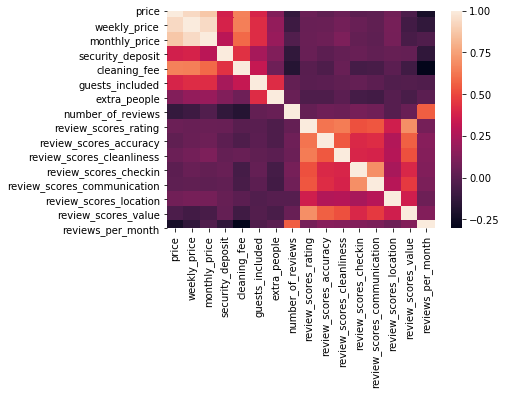

In [96]:
test_df = listing_df[price_cols + rev_cols]
sns.heatmap(test_df.corr());

Size & Price

In [168]:
apt_cols

['property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet']

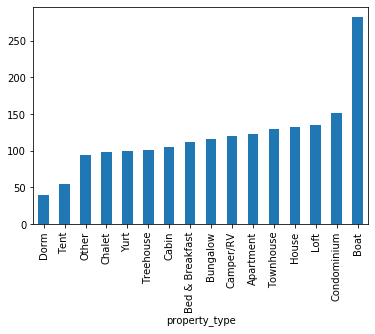

In [176]:
listing_df.groupby('property_type').mean()['price'].sort_values().plot(kind='bar');

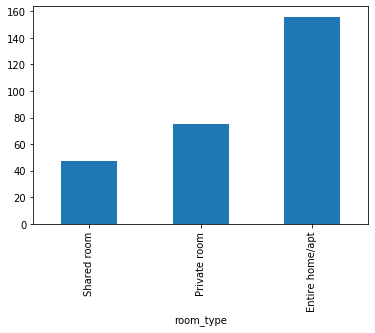

In [177]:
listing_df.groupby('room_type').mean()['price'].sort_values().plot(kind='bar');

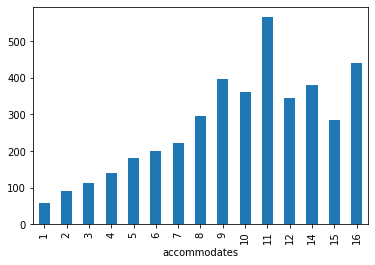

In [180]:
listing_df.groupby('accommodates').mean()['price'].plot(kind='bar');

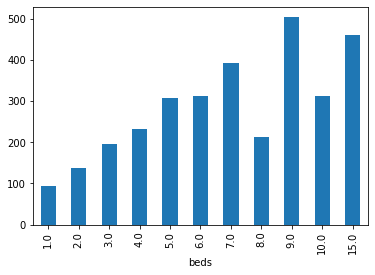

In [182]:
listing_df.groupby('beds').mean()['price'].plot(kind='bar');

Superhosts vs. regular hosts

In [261]:
super_df = listing_df[listing_df['host_is_superhost']=='t']
reg_df = listing_df[listing_df['host_is_superhost']=='f']

In [262]:
super_rev = pd.DataFrame(super_df[rev_cols].mean(), columns = ['value'])
reg_rev = pd.DataFrame(reg_df[rev_cols].mean(), columns = ['value'])
comp_df = pd.merge(super_rev, reg_rev, left_index=True, right_index=True)
comp_df.columns = ['Superhosts', 'Regular Hosts']
comp_df['Delta'] = comp_df['Superhosts'] - comp_df['Regular Hosts']
comp_df.style.bar(subset=['Delta'], align='mid', color=['#d65f5f', '#5fba7d'])

,Superhosts,Regular Hosts,Delta
number_of_reviews,41.7571,17.2357,24.5214
review_scores_rating,97.3955,93.6529,3.74258
review_scores_accuracy,9.90546,9.55251,0.352948
review_scores_cleanliness,9.88549,9.45402,0.431468
review_scores_checkin,9.96405,9.73142,0.232624
review_scores_communication,9.9747,9.75828,0.216422
review_scores_location,9.751,9.56468,0.186322
review_scores_value,9.74967,9.3596,0.390065
reviews_per_month,2.96963,1.80477,1.16486


In [263]:
super_rev = pd.DataFrame(super_df[price_cols].mean(), columns = ['value'])
reg_rev = pd.DataFrame(reg_df[price_cols].mean(), columns = ['value'])
comp_df = pd.merge(super_rev, reg_rev, left_index=True, right_index=True)
comp_df.columns = ['Superhosts', 'Regular Hosts']
comp_df['Delta'] = comp_df['Superhosts'] - comp_df['Regular Hosts']
comp_df.style.bar(subset=['Delta'], align='mid', color=['#d65f5f', '#5fba7d'])

,Superhosts,Regular Hosts,Delta
price,130.14,127.391,2.74873
weekly_price,824.321,777.66,46.6605
monthly_price,2980.99,2495.47,485.52
security_deposit,280.445,289.941,-9.49564
cleaning_fee,58.0924,62.7567,-4.6643
guests_included,1.82905,1.63298,0.196067
extra_people,12.126,10.293,1.83301


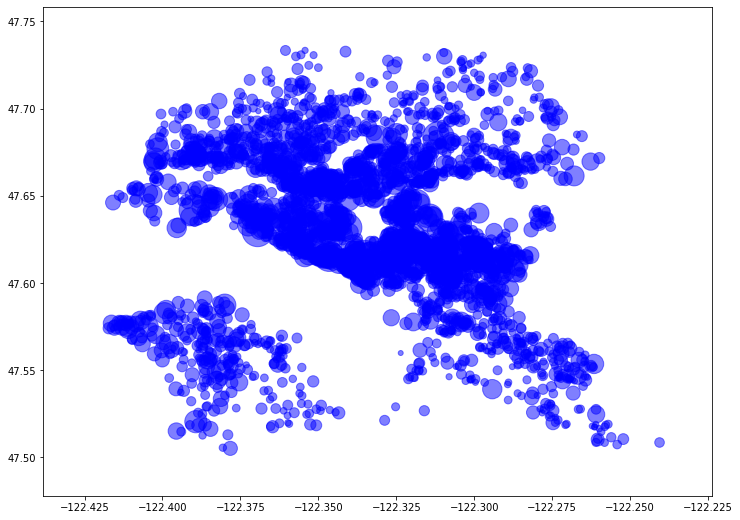

In [267]:
#change size to colormapping
line_plot_fig, line_plot_ax = plt.subplots(figsize=(12,9))
line_plot_ax.scatter(listing_df['longitude'], listing_df['latitude'], s= listing_df['price'], c= "Blue", alpha=0.5);

### Questions

- How to be a great AirBnB host? Do certain host characteristics relate to better reviews? 
- Are Superhosts more sucessful? 
- Where are the most expensive properties located? Does that reflects the current real state prices of the neighbourhood?
- What influences price?
- Are most expensive listings actually better reviewed?
- How does price fluctuate through the year?
- How does availability fluctuate through the year?
- How is price distributed? How do two cities compare?
- Which words are most common in reviews?
- How do ammenities affect the price?
- Which neighbourhoods have the most expensive listings?